### Import libraries

In [1]:
import plotly.graph_objects as go
import gpxpy
import seaborn as sns
import numpy as np
from matplotlib import colormaps
from colorspacious import cspace_converter

import matplotlib.pyplot as plt
import matplotlib as mpl

### To export

Example usage:

fig = plot_gpx('your_file_name.gpx', color_choice='cool', resolution='great')

Export the plot as HTML:

fig.write_html("elevation_plot.html")

Export the plot as an image (e.g., PNG):

fig.write_image("elevation_plot.png")


### Colour theme options

In [2]:
#print(list(colormaps))
cmaps = {}

gradient = np.linspace(0, 1, 256)
gradient = np.vstack((gradient, gradient))


def plot_color_gradients(category, cmap_list):
    # Create figure and adjust figure height to number of colormaps
    nrows = len(cmap_list)
    figh = 0.35 + 0.15 + (nrows + (nrows - 1) * 0.1) * 0.22
    fig, axs = plt.subplots(nrows=nrows + 1, figsize=(6.4, figh))
    fig.subplots_adjust(top=1 - 0.35 / figh, bottom=0.15 / figh,
                        left=0.2, right=0.99)
    axs[0].set_title(f'{category} colormaps', fontsize=14)

    for ax, name in zip(axs, cmap_list):
        ax.imshow(gradient, aspect='auto', cmap=mpl.colormaps[name])
        ax.text(-0.01, 0.5, name, va='center', ha='right', fontsize=10,
                transform=ax.transAxes)

    # Turn off *all* ticks & spines, not just the ones with colormaps.
    for ax in axs:
        ax.set_axis_off()

    # Save colormap list for later.
    cmaps[category] = cmap_list

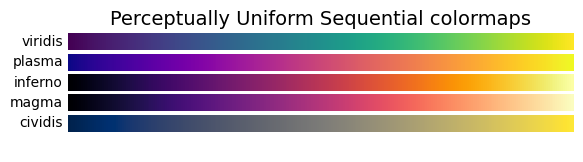

In [3]:
plot_color_gradients('Perceptually Uniform Sequential',
                     ['viridis', 'plasma', 'inferno', 'magma', 'cividis'])

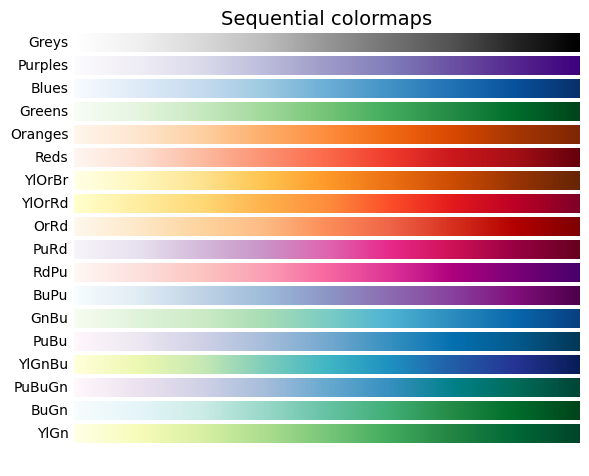

In [4]:
plot_color_gradients('Sequential',
                     ['Greys', 'Purples', 'Blues', 'Greens', 'Oranges', 'Reds',
                      'YlOrBr', 'YlOrRd', 'OrRd', 'PuRd', 'RdPu', 'BuPu',
                      'GnBu', 'PuBu', 'YlGnBu', 'PuBuGn', 'BuGn', 'YlGn'])

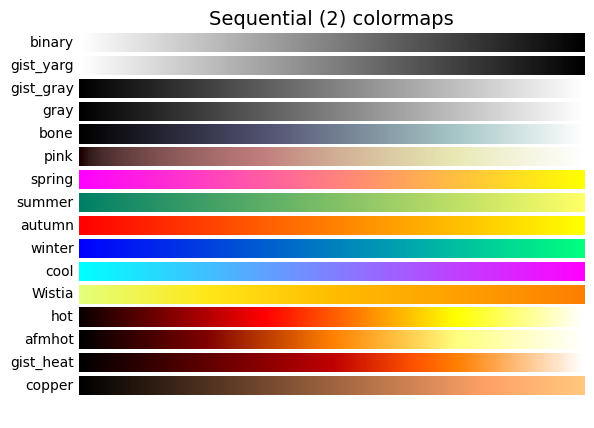

In [5]:
plot_color_gradients('Sequential (2)',
                     ['binary', 'gist_yarg', 'gist_gray', 'gray', 'bone',
                      'pink', 'spring', 'summer', 'autumn', 'winter', 'cool',
                      'Wistia', 'hot', 'afmhot', 'gist_heat', 'copper'])

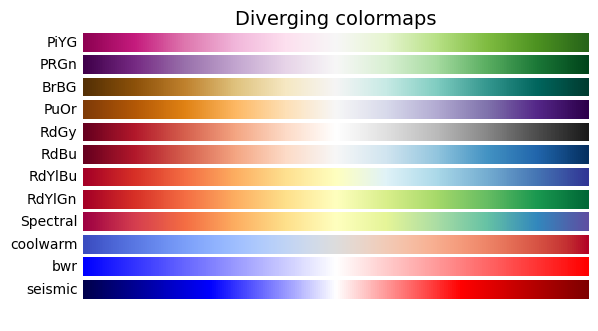

In [6]:
plot_color_gradients('Diverging',
                     ['PiYG', 'PRGn', 'BrBG', 'PuOr', 'RdGy', 'RdBu', 'RdYlBu',
                      'RdYlGn', 'Spectral', 'coolwarm', 'bwr', 'seismic'])

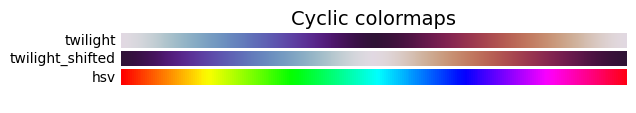

In [7]:
plot_color_gradients('Cyclic', ['twilight', 'twilight_shifted', 'hsv'])

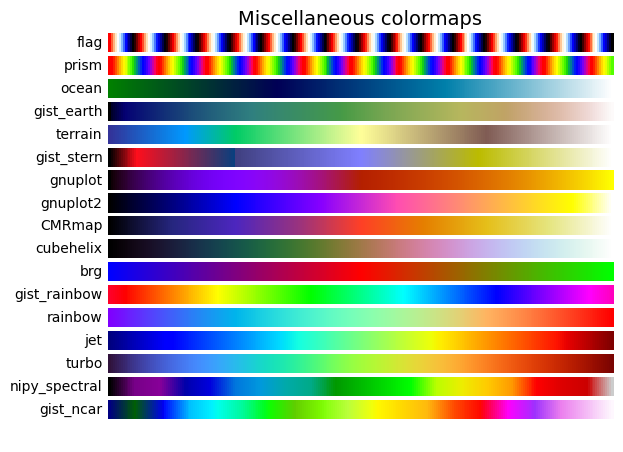

In [8]:
plot_color_gradients('Miscellaneous',
                     ['flag', 'prism', 'ocean', 'gist_earth', 'terrain',
                      'gist_stern', 'gnuplot', 'gnuplot2', 'CMRmap',
                      'cubehelix', 'brg', 'gist_rainbow', 'rainbow', 'jet',
                      'turbo', 'nipy_spectral', 'gist_ncar'])

### Function to extract XYZ coordinates from GPX file

In [9]:
def extract_xyz_from_gpx(gpx_file):
    points = []

    with open(gpx_file, 'r') as gpx:
        gpx_data = gpx.read()
        gpx_parser = gpxpy.parse(gpx_data)

        for track in gpx_parser.tracks:
            for segment in track.segments:
                for point in segment.points:
                    points.append((point.longitude, point.latitude, point.elevation))

    return points

### Plot with solid colours

In [10]:
def plot_gpx_solid(gpx_file, line_color='black', point_color='black', line_width=2, point_size=2, resolution='good'):
    # Extract XYZ coordinates from GPX file
    xyz_coordinates = extract_xyz_from_gpx(gpx_file)

    # Separate XYZ coordinates into individual lists
    x, y, z = zip(*xyz_coordinates)
    
    # Determine the resolution
    if resolution == 'great':
        step = 5
    elif resolution == 'good':
        step = 10
    elif resolution == 'insane':
        step = 1
    else:  # Default to 'okay'
        step = 20
    
    # Get the length of the lower resolution ride
    LengthLowerRes = len(range(0, len(x), step))

    
    # Create the plot
    fig = go.Figure()

    # Add lines from (x, y, 0) to (x, y, z) for each point
    for i in range(LengthLowerRes):
        adj_i = i*step
        fig.add_trace(go.Scatter3d(x=[x[adj_i], x[adj_i]], y=[y[adj_i], y[adj_i]], z=[0, z[adj_i]], mode='lines', 
                                    line=dict(color=line_color, width=line_width),
                                    showlegend=False))

    # Add original points to the plot as small points
    fig.add_trace(go.Scatter3d(x=x, y=y, z=z, mode='markers', marker=dict(color=point_color, size=point_size), name=''))
    fig.add_trace(go.Scatter3d(x=x, y=y, z=[0]*len(x), mode='markers', marker=dict(color=point_color, size=point_size), name=''))

    # set background color
    fig.update_layout(scene=dict(
                        xaxis=dict(
                            backgroundcolor="light grey",
                            gridcolor="white",
                            showbackground=True,
                            zerolinecolor="white",
                            title='Longitude'),
                        yaxis=dict(
                            backgroundcolor="light grey",
                            gridcolor="white",
                            showbackground=True,
                            zerolinecolor="white",
                            title='Latitude'),
                        zaxis=dict(
                            backgroundcolor="silver",
                            gridcolor="white",
                            showbackground=True,
                            zerolinecolor="white",
                            title='Elevation')),
                      width=1000,
                      height=1000)

    # Return the plot
    return fig

In [11]:
#plot_gpx_solid('oxloop.gpx', line_color='royalblue', resolution='good')

### Plot with a spectrum of colours

In [12]:
def plot_gpx(gpx_file, color_choice='cool', point_color='black', line_width=2, point_size=2, resolution='good'):
    # Extract XYZ coordinates from GPX file
    xyz_coordinates = extract_xyz_from_gpx(gpx_file)

    # Separate XYZ coordinates into individual lists
    x, y, z = zip(*xyz_coordinates)
    
    # Determine the resolution
    if resolution == 'great':
        step = 5
    elif resolution == 'good':
        step = 10
    elif resolution == 'insane':
        step = 1
    else:
        step = 20
    
    # Get the length of the lower resolution ride
    LengthLowerRes = len(range(0, len(x), step))
    cmap = plt.get_cmap(color_choice)  # Choosing a colormap
    colors = [cmap(i / LengthLowerRes) for i in range(LengthLowerRes)]
    
    # Create the plot
    fig = go.Figure()

    # Add lines from (x, y, 0) to (x, y, z) for each point
    for i in range(LengthLowerRes):
        adj_i = i * step
        fig.add_trace(go.Scatter3d(x=[x[adj_i], x[adj_i]], y=[y[adj_i], y[adj_i]], z=[0, z[adj_i]], mode='lines', 
                                    line=dict(color='rgb({}, {}, {})'.format(*[int(255 * c) for c in colors[i][:3]]), width=line_width),
                                    showlegend=False))

    # Add original points to the plot as small points
    fig.add_trace(go.Scatter3d(x=x, y=y, z=z, mode='markers', marker=dict(color=point_color, size=point_size), name=''))
    fig.add_trace(go.Scatter3d(x=x, y=y, z=[0] * len(x), mode='markers', marker=dict(color=point_color, size=point_size), name=''))
    
    # Set up the plot
    fig.update_layout(scene=dict(
                        xaxis=dict(
                            backgroundcolor="light grey",
                            gridcolor="white",
                            showbackground=True,
                            zerolinecolor="white",
                            title='Longitude'),
                        yaxis=dict(
                            backgroundcolor="light grey",
                            gridcolor="white",
                            showbackground=True,
                            zerolinecolor="white",
                            title='Latitude'),
                        zaxis=dict(
                            backgroundcolor="silver",
                            gridcolor="white",
                            showbackground=True,
                            zerolinecolor="white",
                            title='Elevation')),
                      width=1000,
                      height=1000)

    # Return the plot
    return fig

In [13]:
#plot_gpx('oxloop.gpx', color_choice='cool', resolution='great')

In [14]:
#plot_gpx('oxloop.gpx', color_choice='twilight', resolution='okay', point_size=4)

In [15]:
#plot_gpx('oxloop.gpx', color_choice='viridis', resolution='good', point_size=4, line_width=3)

In [16]:
#fig = plot_gpx('oxloop.gpx', color_choice='cool', resolution='great')
#fig.write_html("elevation_plot.html")

In [17]:
#fig = plot_gpx('Triple.gpx', color_choice='twilight', resolution='great', point_size=5, line_width=3)
#fig = plot_gpx('Triple.gpx', color_choice='plasma', resolution='great', point_size=3, line_width=1)
#fig = plot_gpx('Triple.gpx', color_choice='PuBu', resolution='great', point_size=3, line_width=2)
#fig = plot_gpx('Triple.gpx', color_choice='rainbow', resolution='great', point_size=3, line_width=1)

#fig.write_html("Triple_rainbow.html")
#coord = extract_xyz_from_gpx('Triple.gpx') # 23566 distinct points, 26443 rows